In [2]:
# 1. Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [3]:
# 2. Load the Dataset from CSV
data = pd.read_csv('flood.csv')

# 3. Display basic information and preview
print("Data Preview:\n", data.head())
print("Data Summary:\n", data.describe())

Data Preview:
    MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ...  DrainageSystems  Coastal

In [4]:
# 4. Preprocess the Data
X = data.drop('FloodProbability', axis=1)  # Features
y = data['FloodProbability']               # Target variable

# 5. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 6. Evaluation Function (includes accuracy, MSE, MAE, R², time)
def evaluate_model_with_accuracy(model, model_name):
    results = {}
    
    # 1. Measure Training Time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # 2. Measure Prediction Time
    start_time = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # 3. Compute Metrics
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, y_pred)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    train_mae = mean_absolute_error(y_train, model.predict(X_train))
    test_mae = mean_absolute_error(y_test, y_pred)

    # Cross-Validation Score (5-Fold)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    cv_mse = -cv_scores.mean()

    # 4. Accuracy Check: Percentage of Predictions within 10% of Actual Values
    tolerance = 0.10  # 10% tolerance
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) <= tolerance) * 100

    # Store Results
    results['Model'] = model_name
    results['Training MSE'] = train_mse
    results['Testing MSE'] = test_mse
    results['Training R²'] = train_r2
    results['Testing R²'] = test_r2
    results['Training MAE'] = train_mae
    results['Testing MAE'] = test_mae
    results['Training Time'] = train_time
    results['Prediction Time'] = pred_time
    results['Cross-Validation MSE'] = cv_mse
    results['Accuracy (within 10% tolerance)'] = accuracy

    return results, y_pred

In [16]:
# 7. Initialize Models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr_model = SVR(kernel='rbf', C=1.0)
lr_model = LinearRegression()

In [17]:
# 8. Evaluate Models with Accuracy
rf_results, rf_pred = evaluate_model_with_accuracy(rf_model, 'Random Forest')
gb_results, gb_pred = evaluate_model_with_accuracy(gb_model, 'Gradient Boosting')
svr_results, svr_pred = evaluate_model_with_accuracy(svr_model, 'Support Vector Regression')
lr_results, lr_pred = evaluate_model_with_accuracy(lr_model, 'Linear Regression')

In [18]:
# 9. Compile all results into a DataFrame
results_df = pd.DataFrame([rf_results, gb_results, svr_results, lr_results])

# Add Ranking based on Testing MSE (Lower is Better)
results_df['Rank'] = results_df['Testing MSE'].rank(ascending=True)

# Sort models based on rank
results_df_sorted = results_df.sort_values(by='Rank')

# Display the final comparison table
print("\n--- Model Comparison with Ranking ---\n")
print(results_df_sorted[['Model', 'Testing MSE', 'Testing R²', 'Testing MAE', 'Accuracy (within 10% tolerance)', 'Training Time', 'Prediction Time', 'Cross-Validation MSE', 'Rank']])


--- Model Comparison with Ranking ---

                       Model   Testing MSE  Testing R²   Testing MAE  \
3          Linear Regression  1.103552e-31    1.000000  2.651601e-16   
1          Gradient Boosting  5.505254e-04    0.778957  1.848071e-02   
0              Random Forest  6.732505e-04    0.729682  2.048472e-02   
2  Support Vector Regression  6.971302e-04    0.720094  2.015667e-02   

   Accuracy (within 10% tolerance)  Training Time  Prediction Time  \
3                           100.00       0.026391         0.001088   
1                            95.80       7.000332         0.025638   
0                            94.41      30.817640         0.353208   
2                            91.97       0.113531         0.043600   

   Cross-Validation MSE  Rank  
3          2.636353e-31   1.0  
1          5.456465e-04   2.0  
0          6.862117e-04   3.0  
2          7.530162e-04   4.0  


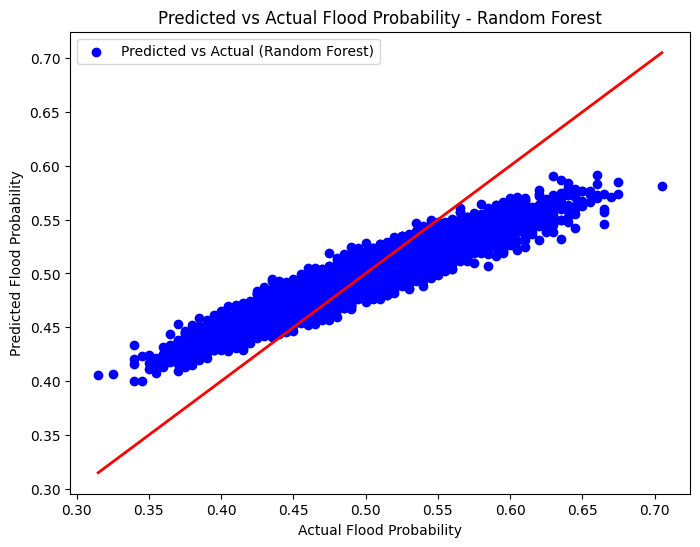

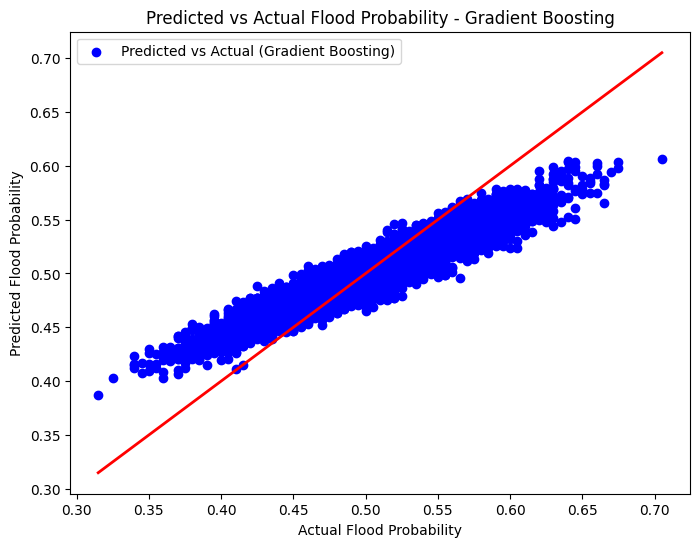

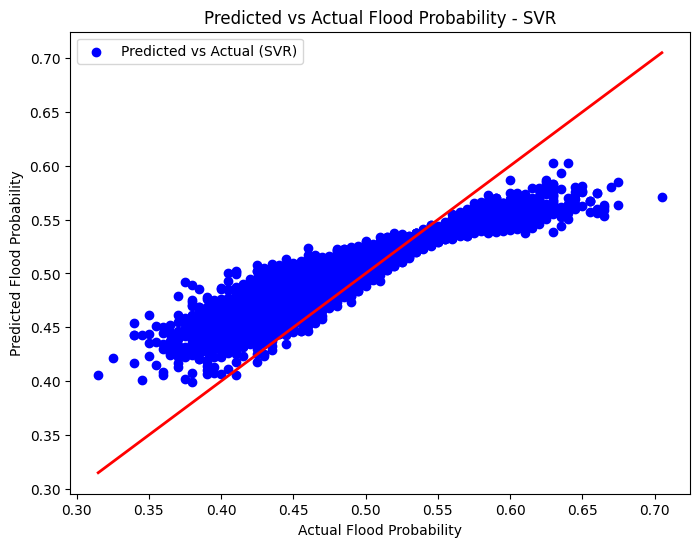

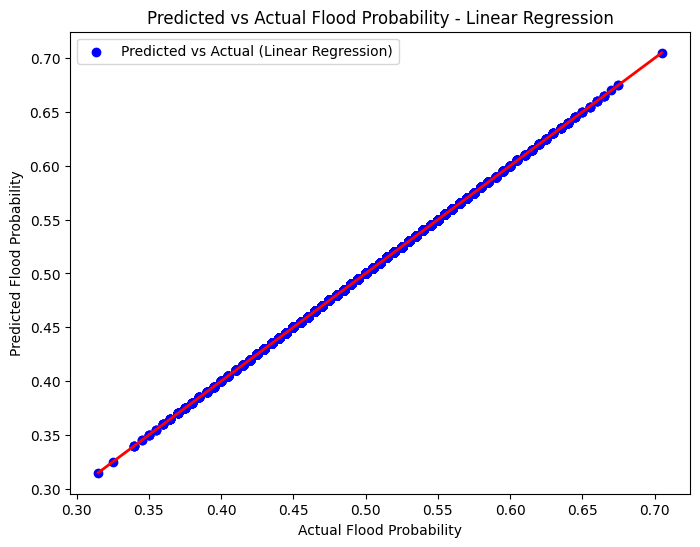

In [19]:

# 10. Scatter Plot of Predicted vs Actual Flood Probability for Each Model
models_preds = {'Random Forest': rf_pred, 'Gradient Boosting': gb_pred, 'SVR': svr_pred, 'Linear Regression': lr_pred}
for model_name, y_pred in models_preds.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label=f'Predicted vs Actual ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.title(f'Predicted vs Actual Flood Probability - {model_name}')
    plt.xlabel('Actual Flood Probability')
    plt.ylabel('Predicted Flood Probability')
    plt.legend()
    plt.show()




In [ ]:
# 11. Residuals (Error Analysis) for Each Model
for model_name, y_pred in models_preds.items():
    plt.figure(figsize=(8, 6))
    residuals = y_test - y_pred
    sns.histplot(residuals, bins=20, kde=True, color='purple')
    plt.title(f'Residuals Distribution (Test Set) - {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

# 12. Feature Importance (for Random Forest and Gradient Boosting)
for model, model_name in [(rf_model, 'Random Forest'), (gb_model, 'Gradient Boosting')]:
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort in descending order of importance

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances ({model_name})")
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()